# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

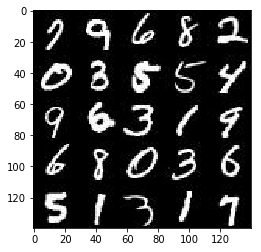

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

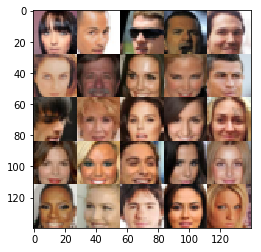

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x1024 now
        
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x512 now
        
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 28x28x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.2 * x4, x4)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # After 10 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    # After 100 steps, print sample images
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10... Epoch 1/2... Discriminator Loss: 4.5556... Generator Loss: 0.0602
Step 20... Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 4.0638
Step 30... Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 5.2697
Step 40... Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 5.3560
Step 50... Epoch 1/2... Discriminator Loss: 1.8617... Generator Loss: 0.4631
Step 60... Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 1.7711
Step 70... Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.9596
Step 80... Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 1.1620
Step 90... Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.4745
Step 100... Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 1.4640


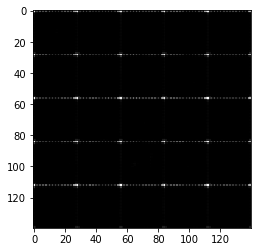

Step 110... Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.7010
Step 120... Epoch 1/2... Discriminator Loss: 1.5793... Generator Loss: 0.4893
Step 130... Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 1.1215
Step 140... Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.8570
Step 150... Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 1.3068
Step 160... Epoch 1/2... Discriminator Loss: 1.0394... Generator Loss: 1.1914
Step 170... Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.1638
Step 180... Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 1.2095
Step 190... Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 2.0793
Step 200... Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.5462


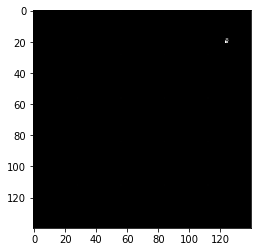

Step 210... Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.4945
Step 220... Epoch 1/2... Discriminator Loss: 1.5507... Generator Loss: 0.4731
Step 230... Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 1.1058
Step 240... Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 0.9002
Step 250... Epoch 1/2... Discriminator Loss: 1.4767... Generator Loss: 0.4940
Step 260... Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.2896
Step 270... Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 1.0505
Step 280... Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.7858
Step 290... Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 1.1754
Step 300... Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.7199


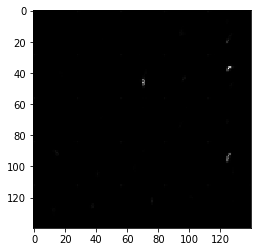

Step 310... Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.8767
Step 320... Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.6636
Step 330... Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.9569
Step 340... Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.6595
Step 350... Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.7566
Step 360... Epoch 1/2... Discriminator Loss: 1.2649... Generator Loss: 0.7159
Step 370... Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.9028
Step 380... Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 0.8875
Step 390... Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.6679
Step 400... Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.6965


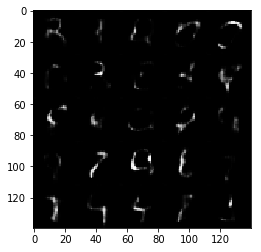

Step 410... Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.0683
Step 420... Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.9180
Step 430... Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 1.3841
Step 440... Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.6156
Step 450... Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.5968
Step 460... Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.9358
Step 470... Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.7502
Step 480... Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 1.0785
Step 490... Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.9198
Step 500... Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 1.2017


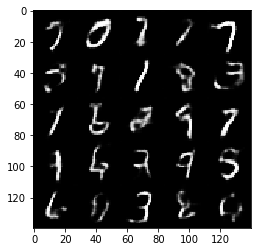

Step 510... Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.6365
Step 520... Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.5947
Step 530... Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 0.9415
Step 540... Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 1.2225
Step 550... Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.5707
Step 560... Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 1.2372
Step 570... Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 1.0296
Step 580... Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.8210
Step 590... Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 1.5602
Step 600... Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 0.5280


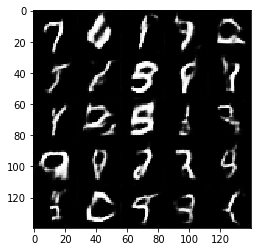

Step 610... Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 1.2398
Step 620... Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.8042
Step 630... Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.8532
Step 640... Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 1.3722
Step 650... Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6013
Step 660... Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 0.8702
Step 670... Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.8372
Step 680... Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.5461
Step 690... Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.9626
Step 700... Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 1.1065


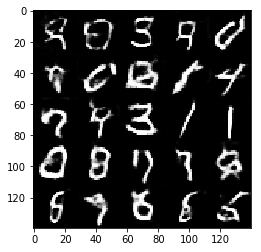

Step 710... Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 1.3200
Step 720... Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 1.2480
Step 730... Epoch 1/2... Discriminator Loss: 1.5473... Generator Loss: 0.4265
Step 740... Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 1.1310
Step 750... Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.5707
Step 760... Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.9584
Step 770... Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 0.5921
Step 780... Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 1.3334
Step 790... Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 1.1217
Step 800... Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 1.0677


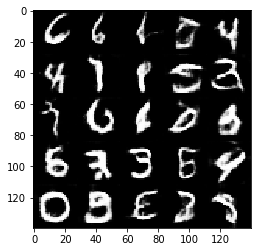

Step 810... Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.5852
Step 820... Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6526
Step 830... Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 1.1827
Step 840... Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.6399
Step 850... Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 1.4356
Step 860... Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 1.2122
Step 870... Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 1.0715
Step 880... Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 1.1253
Step 890... Epoch 1/2... Discriminator Loss: 1.5676... Generator Loss: 0.4438
Step 900... Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.7283


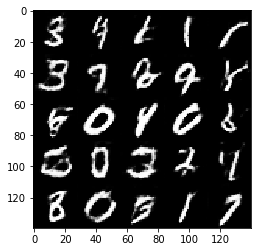

Step 910... Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.4586
Step 920... Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.8986
Step 930... Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.9836
Step 940... Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 1.2853
Step 950... Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 1.0090
Step 960... Epoch 2/2... Discriminator Loss: 1.2511... Generator Loss: 0.9413
Step 970... Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.8146
Step 980... Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.6991
Step 990... Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.8787
Step 1000... Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.9184


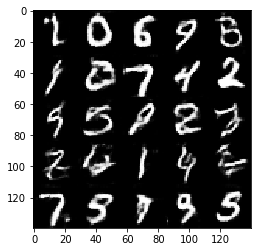

Step 1010... Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 1.3688
Step 1020... Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.9028
Step 1030... Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.6739
Step 1040... Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 1.5570
Step 1050... Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 0.7987
Step 1060... Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 1.3566
Step 1070... Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 1.1145
Step 1080... Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.6148
Step 1090... Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.7051
Step 1100... Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 1.2546


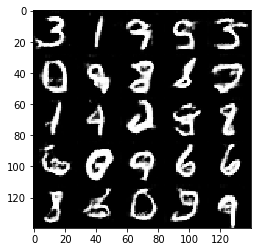

Step 1110... Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.6899
Step 1120... Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 1.2746
Step 1130... Epoch 2/2... Discriminator Loss: 1.5503... Generator Loss: 0.4253
Step 1140... Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 1.3490
Step 1150... Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.6697
Step 1160... Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 0.9085
Step 1170... Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.5209
Step 1180... Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 1.1349
Step 1190... Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 1.2103
Step 1200... Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.7150


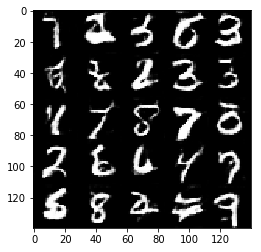

Step 1210... Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 0.4763
Step 1220... Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.7897
Step 1230... Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 0.7947
Step 1240... Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.6624
Step 1250... Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.5974
Step 1260... Epoch 2/2... Discriminator Loss: 1.1465... Generator Loss: 0.9620
Step 1270... Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 1.2895
Step 1280... Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.8309
Step 1290... Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.8490
Step 1300... Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.6486


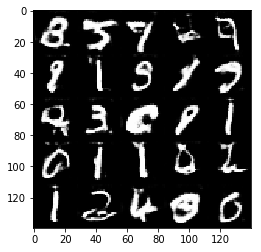

Step 1310... Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 0.9780
Step 1320... Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.1182
Step 1330... Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.5812
Step 1340... Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.7103
Step 1350... Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 1.6376
Step 1360... Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 1.2420
Step 1370... Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.6438
Step 1380... Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.7549
Step 1390... Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.4534
Step 1400... Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 1.2509


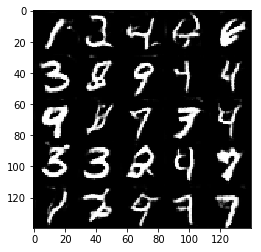

Step 1410... Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.9603
Step 1420... Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.6187
Step 1430... Epoch 2/2... Discriminator Loss: 1.2341... Generator Loss: 0.8076
Step 1440... Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 0.7830
Step 1450... Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.6440
Step 1460... Epoch 2/2... Discriminator Loss: 1.5738... Generator Loss: 0.4368
Step 1470... Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.7487
Step 1480... Epoch 2/2... Discriminator Loss: 1.1802... Generator Loss: 1.2442
Step 1490... Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.6456
Step 1500... Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.6667


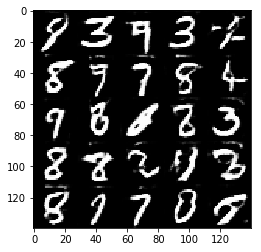

Step 1510... Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 1.2666
Step 1520... Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.0609
Step 1530... Epoch 2/2... Discriminator Loss: 1.4815... Generator Loss: 2.2046
Step 1540... Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 1.2516
Step 1550... Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.6838
Step 1560... Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 1.0891
Step 1570... Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 1.1126
Step 1580... Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.9315
Step 1590... Epoch 2/2... Discriminator Loss: 1.4669... Generator Loss: 1.8631
Step 1600... Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 1.1221


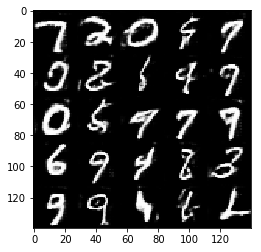

Step 1610... Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 1.0391
Step 1620... Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.8198
Step 1630... Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.8302
Step 1640... Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.5989
Step 1650... Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.5619
Step 1660... Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 1.7579
Step 1670... Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.9794
Step 1680... Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 1.3310
Step 1690... Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 0.9186
Step 1700... Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 0.7230


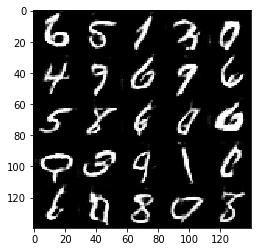

Step 1710... Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.5234
Step 1720... Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 1.1306
Step 1730... Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 1.2599
Step 1740... Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.8711
Step 1750... Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.5794
Step 1760... Epoch 2/2... Discriminator Loss: 2.0699... Generator Loss: 3.0633
Step 1770... Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.6888
Step 1780... Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.5401
Step 1790... Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.6522
Step 1800... Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 0.9451


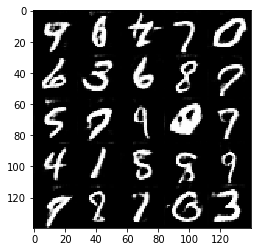

Step 1810... Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.6939
Step 1820... Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.9496
Step 1830... Epoch 2/2... Discriminator Loss: 1.6106... Generator Loss: 2.4042
Step 1840... Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 1.0209
Step 1850... Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 2.0354
Step 1860... Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 1.5606
Step 1870... Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.1909


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10... Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 4.7919
Step 20... Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 3.9770
Step 30... Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.6434
Step 40... Epoch 1/1... Discriminator Loss: 0.4416... Generator Loss: 4.0465
Step 50... Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 4.7306
Step 60... Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 3.5807
Step 70... Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 3.6324
Step 80... Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.3718
Step 90... Epoch 1/1... Discriminator Loss: 3.2570... Generator Loss: 0.0928
Step 100... Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 3.0711


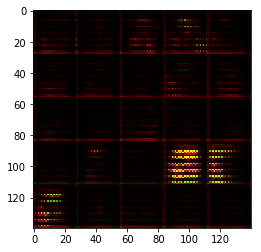

Step 110... Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 3.8723
Step 120... Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.0748
Step 130... Epoch 1/1... Discriminator Loss: 2.4688... Generator Loss: 8.1650
Step 140... Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.5685
Step 150... Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.6840
Step 160... Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.3193
Step 170... Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.5177
Step 180... Epoch 1/1... Discriminator Loss: 3.1504... Generator Loss: 0.1234
Step 190... Epoch 1/1... Discriminator Loss: 1.6591... Generator Loss: 0.5497
Step 200... Epoch 1/1... Discriminator Loss: 1.7435... Generator Loss: 0.9875


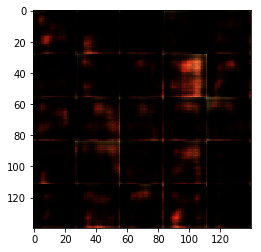

Step 210... Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6735
Step 220... Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5695
Step 230... Epoch 1/1... Discriminator Loss: 1.8351... Generator Loss: 2.3066
Step 240... Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.9506
Step 250... Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.3906
Step 260... Epoch 1/1... Discriminator Loss: 1.6699... Generator Loss: 0.3920
Step 270... Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7841
Step 280... Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.9320
Step 290... Epoch 1/1... Discriminator Loss: 1.8692... Generator Loss: 2.2336
Step 300... Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7401


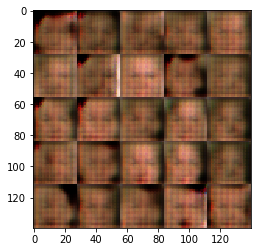

Step 310... Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.4574
Step 320... Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 1.0420
Step 330... Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.9881
Step 340... Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.1593
Step 350... Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.4350
Step 360... Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.0953
Step 370... Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.5482
Step 380... Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 1.4035
Step 390... Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9149
Step 400... Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7891


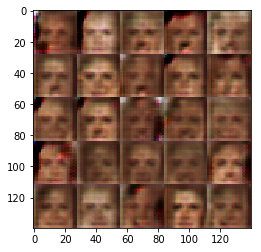

Step 410... Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6652
Step 420... Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 1.9333
Step 430... Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7551
Step 440... Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6511
Step 450... Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.0206
Step 460... Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.9198
Step 470... Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.9439
Step 480... Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6653
Step 490... Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 1.7618
Step 500... Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.4631


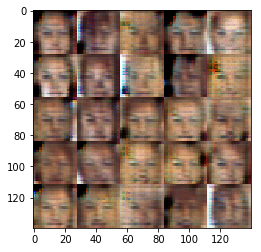

Step 510... Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.2153
Step 520... Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 2.3566
Step 530... Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8807
Step 540... Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.7995
Step 550... Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5484
Step 560... Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 1.4120
Step 570... Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8131
Step 580... Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.3862
Step 590... Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.6935
Step 600... Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8569


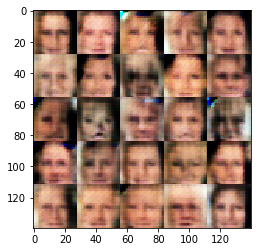

Step 610... Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7625
Step 620... Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.9743
Step 630... Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.5988
Step 640... Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 1.0481
Step 650... Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.0086
Step 660... Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 1.2007
Step 670... Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 1.6091
Step 680... Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8780
Step 690... Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.3461
Step 700... Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6666


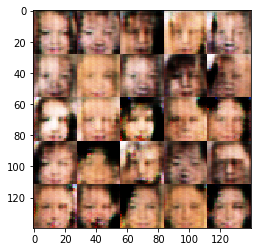

Step 710... Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.1679
Step 720... Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 1.2167
Step 730... Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.0756
Step 740... Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8767
Step 750... Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7638
Step 760... Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.9821
Step 770... Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6768
Step 780... Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 1.0709
Step 790... Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6686
Step 800... Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6533


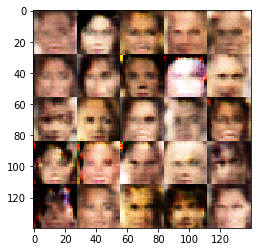

Step 810... Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7926
Step 820... Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8657
Step 830... Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.1839
Step 840... Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.0324
Step 850... Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8314
Step 860... Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5228
Step 870... Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7946
Step 880... Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.7500
Step 890... Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8153
Step 900... Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.9496


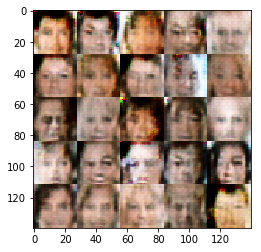

Step 910... Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 1.1692
Step 920... Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6011
Step 930... Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.0381
Step 940... Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.5720
Step 950... Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6782
Step 960... Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.0156
Step 970... Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6032
Step 980... Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.0053
Step 990... Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 1.0799
Step 1000... Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7687


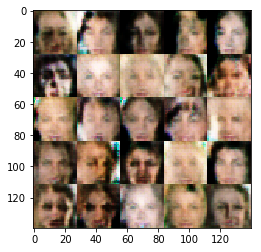

Step 1010... Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.5768
Step 1020... Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 1.3832
Step 1030... Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7741
Step 1040... Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5929
Step 1050... Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8164
Step 1060... Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.9974
Step 1070... Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6471
Step 1080... Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 1.3952
Step 1090... Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8376
Step 1100... Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6035


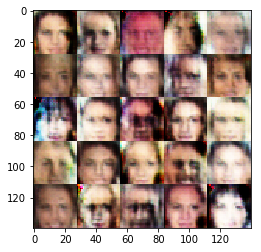

Step 1110... Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.7827
Step 1120... Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7290
Step 1130... Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 1.1281
Step 1140... Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.8736
Step 1150... Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8804
Step 1160... Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6809
Step 1170... Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.5486
Step 1180... Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.5529
Step 1190... Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.6124
Step 1200... Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8945


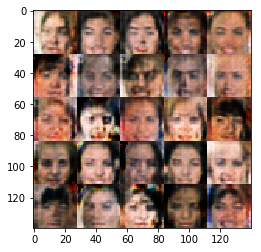

Step 1210... Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.5829
Step 1220... Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8990
Step 1230... Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.9266
Step 1240... Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.7694
Step 1250... Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8721
Step 1260... Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.9477
Step 1270... Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.4204
Step 1280... Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8217
Step 1290... Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.0244
Step 1300... Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5874


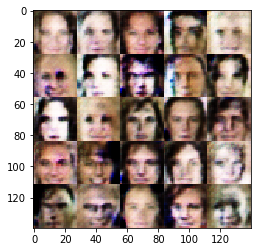

Step 1310... Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8726
Step 1320... Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.8418
Step 1330... Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 1.0012
Step 1340... Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 1.0592
Step 1350... Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.9664
Step 1360... Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9921
Step 1370... Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7234
Step 1380... Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.1541
Step 1390... Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7460
Step 1400... Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8699


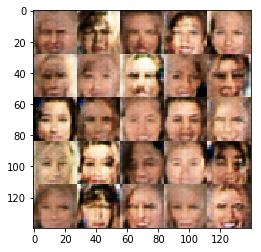

Step 1410... Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 1.5312
Step 1420... Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7589
Step 1430... Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.4394
Step 1440... Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8751
Step 1450... Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.9108
Step 1460... Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6891
Step 1470... Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6879
Step 1480... Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8797
Step 1490... Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.9805
Step 1500... Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7054


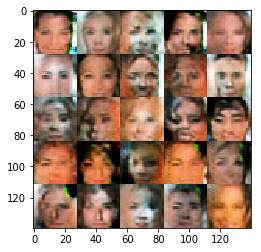

Step 1510... Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7495
Step 1520... Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8773
Step 1530... Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.5697
Step 1540... Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6699
Step 1550... Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5995
Step 1560... Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5574
Step 1570... Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 1.0597
Step 1580... Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7304
Step 1590... Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.8265
Step 1600... Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.5290


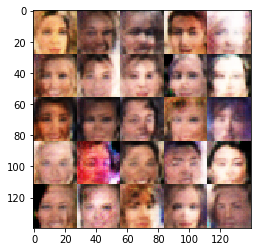

Step 1610... Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 1.1984
Step 1620... Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7513
Step 1630... Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.8023
Step 1640... Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7695
Step 1650... Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0198
Step 1660... Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7491
Step 1670... Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.5864
Step 1680... Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.5707
Step 1690... Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.6985
Step 1700... Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8928


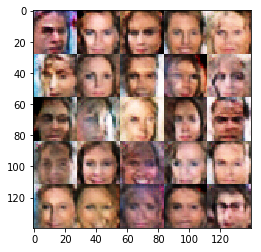

Step 1710... Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8158
Step 1720... Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7973
Step 1730... Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6914
Step 1740... Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.9620
Step 1750... Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 1.2067
Step 1760... Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5503
Step 1770... Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8612
Step 1780... Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5453
Step 1790... Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.4867
Step 1800... Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 1.0344


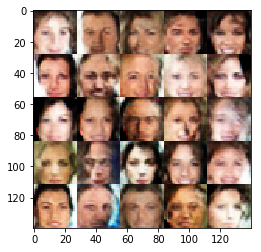

Step 1810... Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.8007
Step 1820... Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.8493
Step 1830... Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8442
Step 1840... Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8921
Step 1850... Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8392
Step 1860... Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6868
Step 1870... Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6473
Step 1880... Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7947
Step 1890... Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8599
Step 1900... Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8609


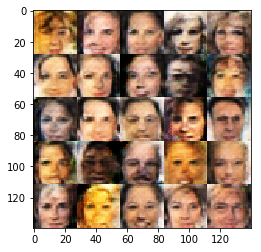

Step 1910... Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.7258
Step 1920... Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.7720
Step 1930... Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.9286
Step 1940... Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6293
Step 1950... Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6597
Step 1960... Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.9098
Step 1970... Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8697
Step 1980... Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7033
Step 1990... Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7556
Step 2000... Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7764


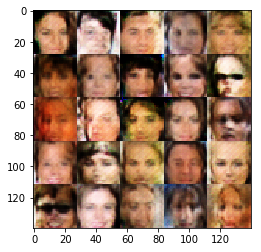

Step 2010... Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7222
Step 2020... Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6794
Step 2030... Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.8591
Step 2040... Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8672
Step 2050... Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6287
Step 2060... Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7525
Step 2070... Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6263
Step 2080... Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6985
Step 2090... Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7710
Step 2100... Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 1.4390


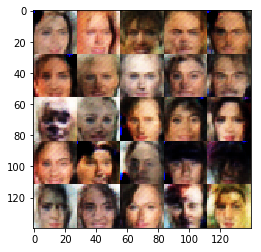

Step 2110... Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7164
Step 2120... Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8174
Step 2130... Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8503
Step 2140... Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8418
Step 2150... Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 1.1656
Step 2160... Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.7424
Step 2170... Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6069
Step 2180... Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8544
Step 2190... Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7354
Step 2200... Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.9956


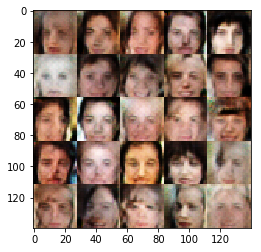

Step 2210... Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8163
Step 2220... Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8153
Step 2230... Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6857
Step 2240... Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.8862
Step 2250... Epoch 1/1... Discriminator Loss: 1.6168... Generator Loss: 0.5828
Step 2260... Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8144
Step 2270... Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.6481
Step 2280... Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8198
Step 2290... Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8794
Step 2300... Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.9441


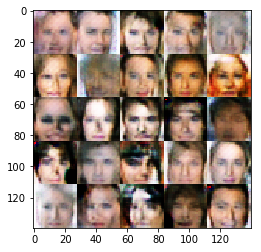

Step 2310... Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.8866
Step 2320... Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.9107
Step 2330... Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.9723
Step 2340... Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.9666
Step 2350... Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.0136
Step 2360... Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7466
Step 2370... Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7779
Step 2380... Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 1.1510
Step 2390... Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.5830
Step 2400... Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7365


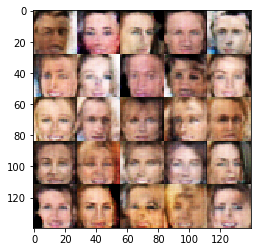

Step 2410... Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 1.0595
Step 2420... Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.9770
Step 2430... Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.9341
Step 2440... Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 1.0439
Step 2450... Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 1.0683
Step 2460... Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.4402
Step 2470... Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.8890
Step 2480... Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 1.2976
Step 2490... Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8242
Step 2500... Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6747


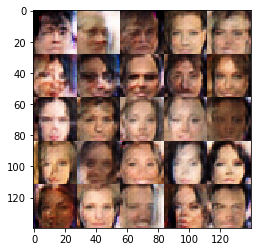

Step 2510... Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6919
Step 2520... Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7243
Step 2530... Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6753
Step 2540... Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8304
Step 2550... Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.9345
Step 2560... Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.9006
Step 2570... Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7754
Step 2580... Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 1.0244
Step 2590... Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8108
Step 2600... Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6854


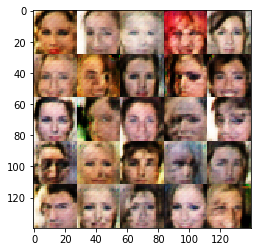

Step 2610... Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8072
Step 2620... Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7764
Step 2630... Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.9480
Step 2640... Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9019
Step 2650... Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8418
Step 2660... Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8783
Step 2670... Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7193
Step 2680... Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.9379
Step 2690... Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8582
Step 2700... Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.0258


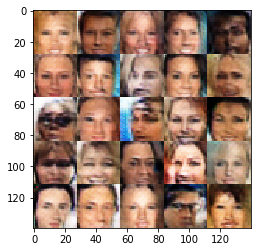

Step 2710... Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6278
Step 2720... Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7828
Step 2730... Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8161
Step 2740... Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8471
Step 2750... Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.9510
Step 2760... Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 1.1301
Step 2770... Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7645
Step 2780... Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7858
Step 2790... Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.0370
Step 2800... Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.1621


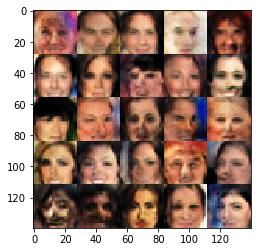

Step 2810... Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8724
Step 2820... Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 1.0201
Step 2830... Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7380
Step 2840... Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7034
Step 2850... Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7000
Step 2860... Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7441
Step 2870... Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7237
Step 2880... Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6461
Step 2890... Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.7905
Step 2900... Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6257


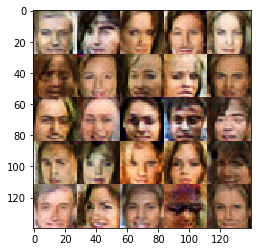

Step 2910... Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8657
Step 2920... Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8564
Step 2930... Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.9164
Step 2940... Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6521
Step 2950... Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9893
Step 2960... Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8105
Step 2970... Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.9237
Step 2980... Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.7791
Step 2990... Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8550
Step 3000... Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7089


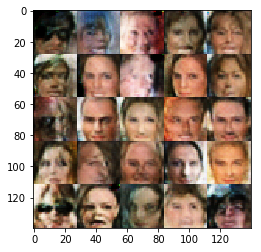

Step 3010... Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7653
Step 3020... Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7500
Step 3030... Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.9171
Step 3040... Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7875
Step 3050... Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8769
Step 3060... Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6178
Step 3070... Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.9283
Step 3080... Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8041
Step 3090... Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7906
Step 3100... Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 1.1027


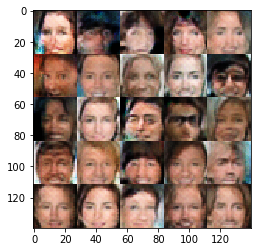

Step 3110... Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.9087
Step 3120... Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.5700
Step 3130... Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8484
Step 3140... Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.9076
Step 3150... Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7968
Step 3160... Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7576


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.